In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.base import clone
from cleaning import *
import sys

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import cm
from matplotlib.colors import LogNorm

In [2]:
from datasetTester import datasetTester

In [3]:
param_sp_svc = {'gamma': [10**x for x in np.linspace(-4, 4, 41)], 'C': [10**x for x in np.linspace(-4, 4, 41)]}

In [4]:
d=datasetTester(path_to_train_set="data/train_mnist_3k.csv", algo='SVC', search='GS', score='ACC', logger='data/train_MNIST.log', param_sp=param_sp_svc)

# GRID SEARCH (COPIED FROM TITANIC ) - NOT MODIFIED TO HANDLE MULTILABEL CLASSIFICATION (ONE VS ALL OR ONE VS ONE) - SHOULD NOT BE USDE - GO DIRECTLY TO NEXT SECTION (RANDOM SEARCH) - ADAPT GRID SEARCH ACCORDINGLY IF YOU WANT

In [ ]:
gs = GridSearchCV(d.algo(), param_grid=d.param_space, n_jobs=4, cv=3, iid=False, verbose=1)

In [ ]:
gs.fit(d.input_data, d.output)

In [ ]:
gs.best_score_, gs.best_params_

In [ ]:
gs_means = [(gs.grid_scores_[i].mean_validation_score) for i in range(len(gs.grid_scores_))]

In [ ]:
gs_stds = [np.std(gs.grid_scores_[i].cv_validation_scores) for i in range(len(gs.grid_scores_))]

In [ ]:
array_means[33, 15], 10**np.linspace(-4,4,41)[33], 10**np.linspace(-4,4,41)[15]

In [ ]:
max(gs_means), max(gs_stds), max(gs_stds)**2

In [ ]:
array_means = np.asarray(gs_means).reshape(tuple([len(x) for x in d.param_space.values()]))

In [ ]:
i_max = [i for i in range(len(array_means)) if np.max(array_means) in array_means[i]][0]
j_max = [j for j in range(len(array_means[i_max])) if np.max(array_means)==array_means[i_max,j]][0]

In [ ]:
i_max, j_max

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
pc = ax.pcolor(param_sp_svc['C'], param_sp_svc['gamma'], array_means.T)
plt.axvline(param_sp_svc['C'][i_max], color='white')
plt.axhline(param_sp_svc['gamma'][j_max], color='white')
plt.colorbar(pc, orientation="vertical")
plt.xlabel('parameter $C$')
plt.ylabel('parameter $\gamma$')
plt.title("Accuracy colorplot (MNIST - SVC RBF - 3xCV)\n Maximum is {0}\n It is reached at {1}\n".format(max(gs_means),(param_sp_svc['C'][i_max], param_sp_svc['gamma'][j_max])))
plt.show()

In [ ]:
a=OneVsRestClassifier(d.algo(), n_jobs=5)

In [ ]:
a.get_params()['estimator__C']=2

In [ ]:
a.set_params(**{'estimator__C': 2.})

# Random search

In [6]:
def transform_param_space_for_one_vs_rest(param_space):
    d = {}
    for key in param_space.keys():
        d['estimator__' + key] = param_space[key]
    return d

In [7]:
from sklearn.multiclass import OneVsRestClassifier
rs = RandomizedSearchCV(OneVsRestClassifier(d.algo(), n_jobs=5),
                        param_distributions=transform_param_space_for_one_vs_rest(d.param_space),
                        n_iter=2, n_jobs=6, cv=3, iid=False, verbose=1)
rs.fit(d.input_data, d.output)


[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.7min finished
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=5),
          fit_params={}, iid=False, n_iter=2, n_jobs=6,
          param_distributions={'estimator__C': [0.0001, 0.00015848931924611142, 0.00025118864315095795, 0.00039810717055349735, 0.00063095734448019298, 0.001, 0.0015848931924611141, 0.002511886431509582, 0.0039810717055349734, 0.0063095734448019303, 0.01, 0.015848931924611141, 0.025118864315095822, 0.03981071...425, 1000.0, 1584.893192461114, 2511.8864315095821, 3981.0717055349774, 6309.573444801943, 10000.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=1)

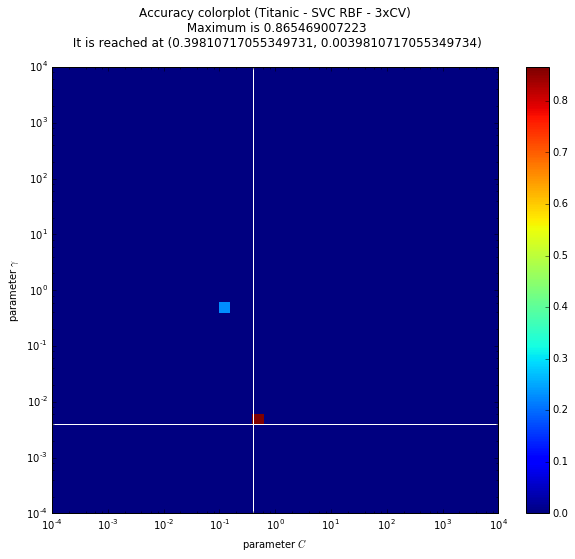

In [10]:
rs_means = [(rs.grid_scores_[i].mean_validation_score) for i in range(len(rs.grid_scores_))]
tested_params=[rs.grid_scores_[i].parameters for i in range(len(rs.grid_scores_))]
tested_scores=[rs.grid_scores_[i].mean_validation_score for i in range(len(rs.grid_scores_))]
tested_C = [test['estimator__C'] for test in tested_params]
tested_gamma = [test['estimator__gamma'] for test in tested_params]
indices_C = [d.param_space['C'].index(tested) for tested in tested_C]
indices_gamma = [d.param_space['gamma'].index(tested) for tested in tested_gamma]
array_means_rs = np.zeros(tuple([len(x) for x in d.param_space.values()]))
for i in range(len(tested_scores)):
    array_means_rs[indices_C[i], indices_gamma[i]] = tested_scores[i]
i_max_rs = [i for i in range(len(array_means_rs)) if np.max(array_means_rs) in array_means_rs[i]][0]
j_max_rs = [j for j in range(len(array_means_rs[i_max_rs])) if np.max(array_means_rs)==array_means_rs[i_max_rs,j]][0]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
pc=ax.pcolor(param_sp_svc['C'], param_sp_svc['gamma'], array_means_rs.T)
plt.axvline(param_sp_svc['C'][i_max_rs], color='white')
plt.axhline(param_sp_svc['gamma'][j_max_rs], color='white')
plt.colorbar(pc, orientation="vertical")
plt.xlabel('parameter $C$')
plt.ylabel('parameter $\gamma$')
plt.title("Accuracy colorplot (MNIST - SVC RBF - 3xCV)\n Maximum is {0}\n It is reached at {1}\n".format(max(rs_means),(param_sp_svc['C'][i_max_rs], param_sp_svc['gamma'][j_max_rs])))
plt.show()

In [ ]:
tested_params

# Replicate

In [11]:
rss = [RandomizedSearchCV(OneVsRestClassifier(d.algo(), n_jobs=5),
                          param_distributions=transform_param_space_for_one_vs_rest(d.param_space),
                          n_iter=20, n_jobs=6, cv=3, iid=False, verbose=1) for _ in range(5)]

In [ ]:
for rs in rss:
    rs.fit(d.input_data, d.output)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 10.7min finished
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i,

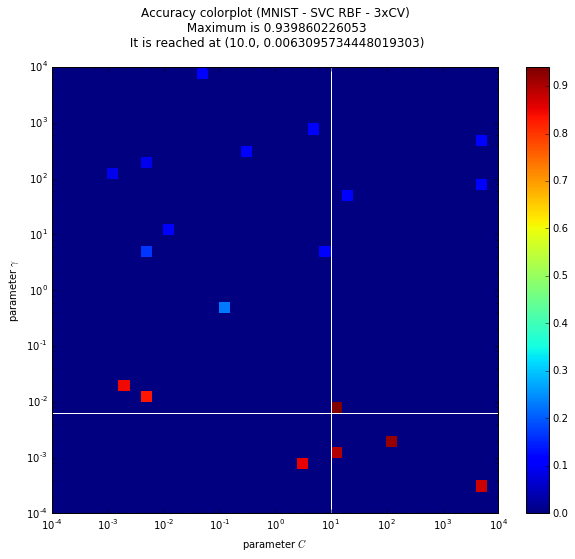

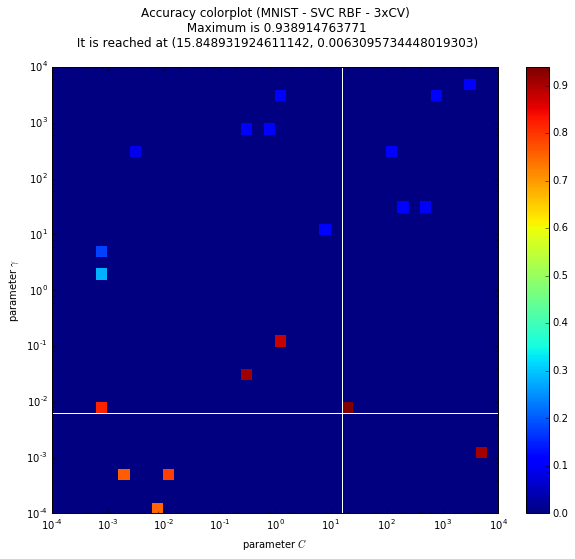

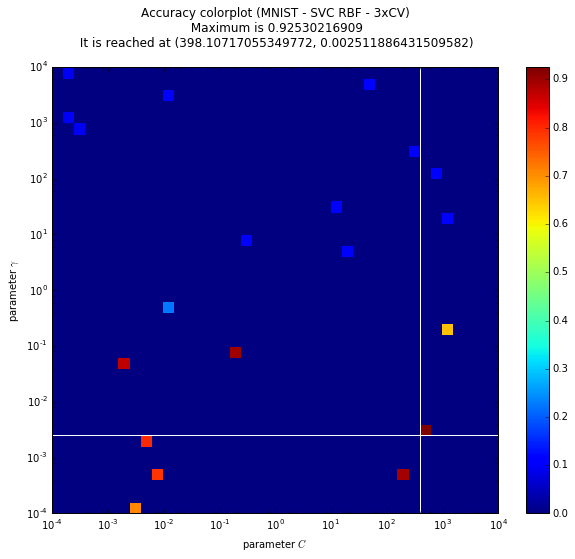

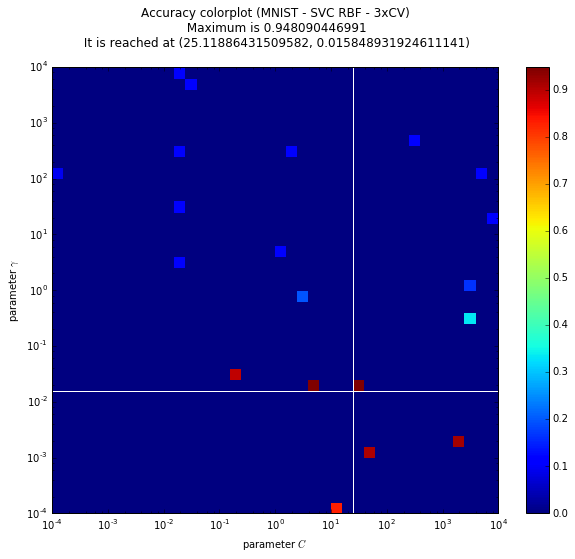

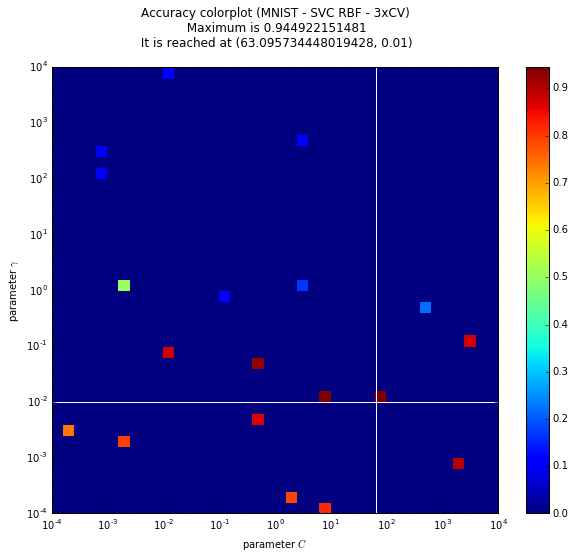

In [14]:
for rs in rss:
    rs_means = [(rs.grid_scores_[i].mean_validation_score) for i in range(len(rs.grid_scores_))]
    tested_params=[rs.grid_scores_[i].parameters for i in range(len(rs.grid_scores_))]
    tested_scores=[rs.grid_scores_[i].mean_validation_score for i in range(len(rs.grid_scores_))]
    tested_C = [test['estimator__C'] for test in tested_params]
    tested_gamma = [test['estimator__gamma'] for test in tested_params]
    indices_C = [d.param_space['C'].index(tested) for tested in tested_C]
    indices_gamma = [d.param_space['gamma'].index(tested) for tested in tested_gamma]
    array_means_rs = np.zeros(tuple([len(x) for x in d.param_space.values()]))
    for i in range(len(tested_scores)):
        array_means_rs[indices_C[i], indices_gamma[i]] = tested_scores[i]
    i_max_rs = [i for i in range(len(array_means_rs)) if np.max(array_means_rs) in array_means_rs[i]][0]
    j_max_rs = [j for j in range(len(array_means_rs[i_max_rs])) if np.max(array_means_rs)==array_means_rs[i_max_rs,j]][0]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    pc=ax.pcolor(param_sp_svc['C'], param_sp_svc['gamma'], array_means_rs.T)
    plt.axvline(param_sp_svc['C'][i_max_rs], color='white')
    plt.axhline(param_sp_svc['gamma'][j_max_rs], color='white')
    plt.colorbar(pc, orientation="vertical")
    plt.xlabel('parameter $C$')
    plt.ylabel('parameter $\gamma$')
    plt.title("Accuracy colorplot (MNIST - SVC RBF - 3xCV)\n Maximum is {0}\n It is reached at {1}\n".format(max(rs_means),(param_sp_svc['C'][i_max_rs], param_sp_svc['gamma'][j_max_rs])))
    plt.show()

In [ ]:
# I FORGOT WHAT THIS CELL DOES - LET'S SKIP IT FOR NOW :)
for rs in rss:
    tested_params=[rs.grid_scores_[i].parameters for i in range(len(rs.grid_scores_))]
    tested_scores=[rs.grid_scores_[i].mean_validation_score for i in range(len(rs.grid_scores_))]
    tested_C = [test['C'] for test in tested_params]
    tested_gamma = [test['gamma'] for test in tested_params]
    indices_C = [d.param_space['C'].index(tested) for tested in tested_C]
    indices_gamma = [d.param_space['gamma'].index(tested) for tested in tested_gamma]
    array_means_rs = np.zeros(tuple([len(x) for x in d.param_space.values()]))

## It seems like (from SeqOpt figures) that the max is more to the right, let's modify things up

In [23]:
param_sp_svc_2 = param_sp_svc
param_sp_svc_2['C'] = list(10 ** np.linspace(2, 8, 41))

In [21]:
d2=datasetTester(path_to_train_set="data/train_mnist_3k.csv", algo='SVC', search='GS', score='ACC', logger='data/train_MNIST_2.log', param_sp=param_sp_svc_2)

In [24]:
rss2 = [RandomizedSearchCV(OneVsRestClassifier(d2.algo(), n_jobs=5),
                          param_distributions=transform_param_space_for_one_vs_rest(d2.param_space),
                          n_iter=20, n_jobs=6, cv=3, iid=False, verbose=1) for _ in range(5)]
for rs in rss2:
    rs.fit(d2.input_data, d2.output)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  7.6min finished
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i, column in enumerate(columns))
/opt/cloudera/extras/anaconda3/envs/python27/lib/python2.7/site-packages/sklearn/multiclass.py:287: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for i,

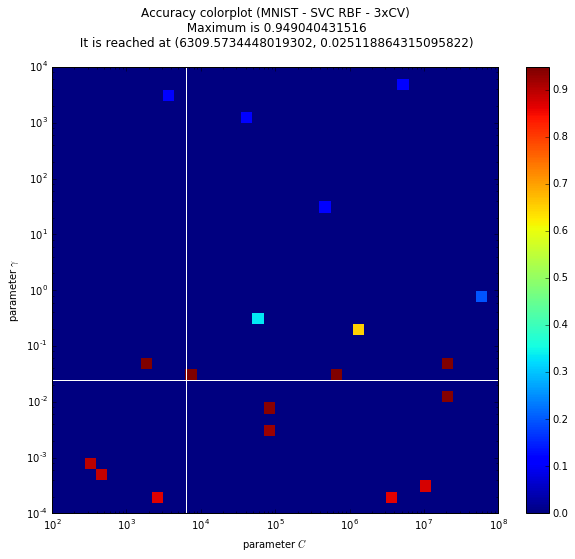

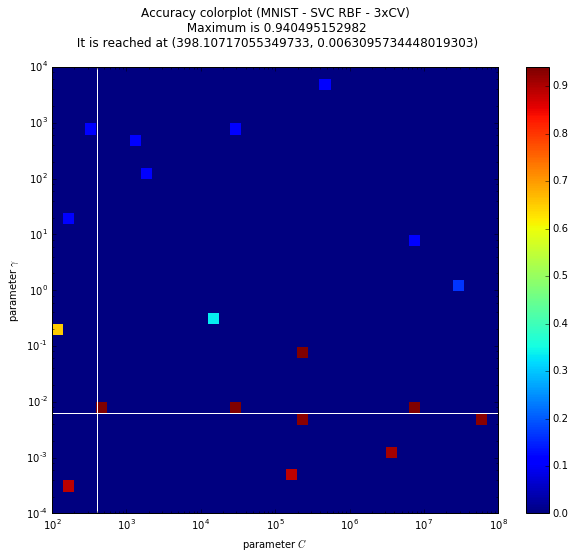

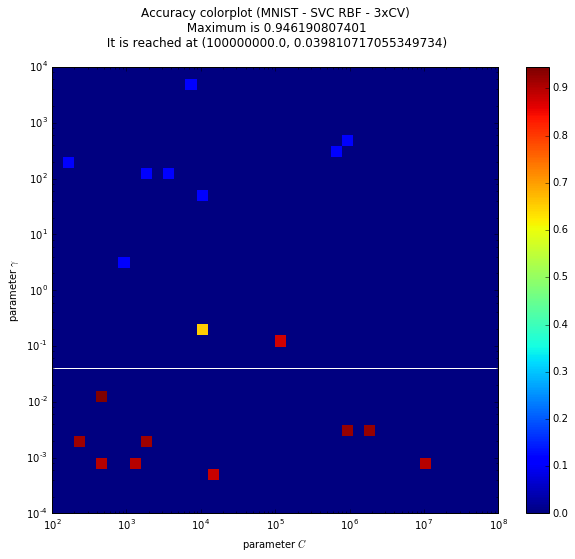

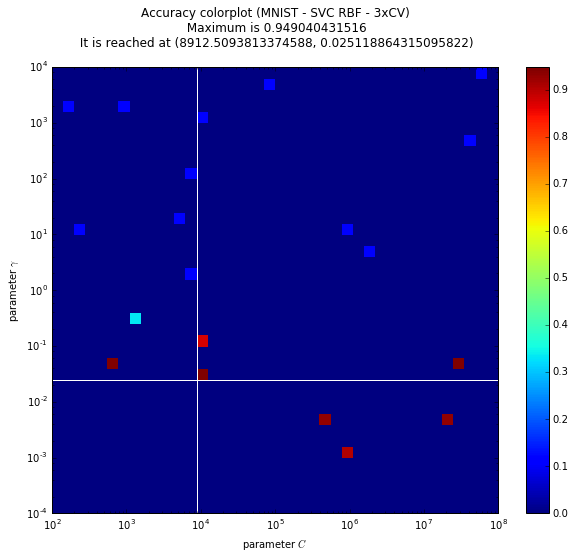

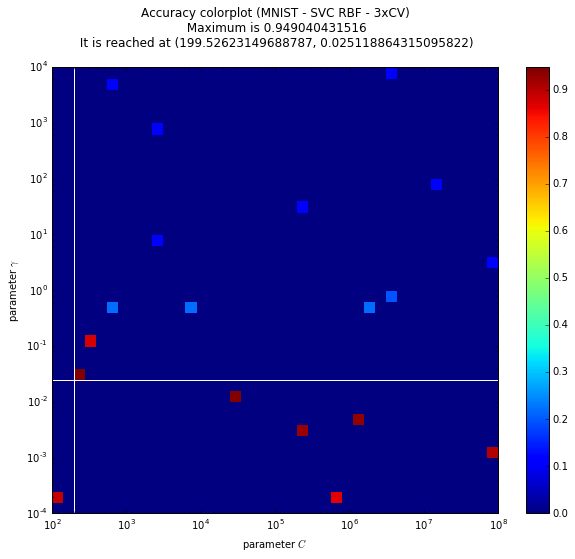

In [26]:
for rs in rss2:
    rs_means = [(rs.grid_scores_[i].mean_validation_score) for i in range(len(rs.grid_scores_))]
    tested_params=[rs.grid_scores_[i].parameters for i in range(len(rs.grid_scores_))]
    tested_scores=[rs.grid_scores_[i].mean_validation_score for i in range(len(rs.grid_scores_))]
    tested_C = [test['estimator__C'] for test in tested_params]
    tested_gamma = [test['estimator__gamma'] for test in tested_params]
    indices_C = [d2.param_space['C'].index(tested) for tested in tested_C]
    indices_gamma = [d2.param_space['gamma'].index(tested) for tested in tested_gamma]
    array_means_rs = np.zeros(tuple([len(x) for x in d2.param_space.values()]))
    for i in range(len(tested_scores)):
        array_means_rs[indices_C[i], indices_gamma[i]] = tested_scores[i]
    i_max_rs = [i for i in range(len(array_means_rs)) if np.max(array_means_rs) in array_means_rs[i]][0]
    j_max_rs = [j for j in range(len(array_means_rs[i_max_rs])) if np.max(array_means_rs)==array_means_rs[i_max_rs,j]][0]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    pc=ax.pcolor(param_sp_svc['C'], param_sp_svc['gamma'], array_means_rs.T)
    plt.axvline(param_sp_svc['C'][i_max_rs], color='white')
    plt.axhline(param_sp_svc['gamma'][j_max_rs], color='white')
    plt.colorbar(pc, orientation="vertical")
    plt.xlabel('parameter $C$')
    plt.ylabel('parameter $\gamma$')
    plt.title("Accuracy colorplot (MNIST - SVC RBF - 3xCV)\n Maximum is {0}\n It is reached at {1}\n".format(max(rs_means),(param_sp_svc['C'][i_max_rs], param_sp_svc['gamma'][j_max_rs])))
    plt.show()

## More examples

In [ ]:
rss2 = [RandomizedSearchCV(OneVsRestClassifier(d2.algo(), n_jobs=5),
                          param_distributions=transform_param_space_for_one_vs_rest(d2.param_space),
                          n_iter=40, n_jobs=6, cv=3, iid=False, verbose=1) for _ in range(20)]
for rs in rss2:
    rs.fit(d2.input_data, d2.output)